# 7. BERT Regressor

Este notebook implementa um modelo de regressão utilizando o BERTimbau, uma versão do modelo BERT treinada para a língua portuguesa. O objetivo é prever o parâmetro `nu_param_B` a partir dos textos dos enunciados. O fluxo inclui etapas de pré-processamento, tokenização, divisão dos dados, treinamento do modelo e avaliação dos resultados.


In [9]:
# Importando dependências para BERT Regressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm_

In [10]:
# Leitura dos Dados
enem_data = pd.read_pickle("enem_data_embeddings.pkl")
enem_data.dropna(subset=["nu_param_B", "enunciado", "alternativas"], inplace=True)
enem_data.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,...,distratores_embbedings_word2vec_100,similaridade_enunciado_gabarito_100,similaridade_enunciado_distratores_100,similaridade_gabarito_distratores_100,enunciado_embbedings_word2vec_50,gabarito_embbedings_word2vec_50,distratores_embbedings_word2vec_50,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,...,"[-0.041815996, -0.06492707, 0.0900044, -0.0498...",0.141353,0.516898,0.151251,"[-0.017395772, -0.004402813, -0.046908338, 0.0...","[-0.16301225, -0.142375, 0.012171499, -0.00457...","[-0.041815996, -0.06492707, 0.0900044, -0.0498...",0.141353,0.516898,0.151251
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,...,"[0.05533243, -0.039066706, -0.059438962, 0.019...",0.422576,0.313321,0.423611,"[-0.051949076, 0.03128451, -0.072241075, 0.028...","[-0.18672037, 0.04755275, -0.17406088, -0.0398...","[0.05533243, -0.039066706, -0.059438962, 0.019...",0.422576,0.313321,0.423611
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,...,"[0.06667993, 0.015803386, 0.029443847, 0.11312...",0.427063,0.471643,0.602545,"[0.026049094, 0.043251127, -0.029757027, -0.00...","[0.011740998, 0.07592634, -0.016144669, 0.1384...","[0.06667993, 0.015803386, 0.029443847, 0.11312...",0.427063,0.471643,0.602545
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,...,"[-0.07921684, 0.10788742, 0.10466367, -0.04121...",0.320939,0.482462,0.421501,"[-0.005251272, 0.039871164, -0.018038195, 0.06...","[-0.073669255, 0.12609875, 0.063628, 0.1261957...","[-0.07921684, 0.10788742, 0.10466367, -0.04121...",0.320939,0.482462,0.421501
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,...,"[-0.02205533, 0.08129784, 0.10641242, -0.05484...",0.304050,0.501346,0.411802,"[0.01738678, 0.0033733728, -0.027247325, 0.002...","[0.11709199, -0.16062833, 0.082869664, -0.1195...","[-0.02205533, 0.08129784, 0.10641242, -0.05484...",0.304050,0.501346,0.411802


## 7.1. Funções Auxiliares

In [11]:
# Iniciando Tokenizer do BERT em Português
tokenizer = AutoTokenizer.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", do_lower_case=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
# Convertendo os dados em DataLoader (Aceitos pelo Pytorch)
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)

    dataset = TensorDataset(input_tensor, mask_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [13]:
# Função para Calcular o R2
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [14]:
# Função para treinamento do modelo BERT com Camada de Regressão e Early Stopping
def train_bert(
    model,
    optimizer,
    scheduler,
    loss_function,
    epochs,
    train_dataloader,
    test_dataloader,
    device,
    patience=3,  # Early Stopping
    clip_value=2,
):
    # Inicializa variáveis para o early stopping
    epochs_no_improve = 0
    best_val_loss = float('inf')

    # Métricas de treino total (valor por época)
    loss_list = []
    rmse_list = []
    r2_train_list = []
    epoch_list = []

    # Métricas de teste total (valor por época)
    test_loss_list = []
    test_rmse_list = []
    r2_test_list = []

    for epoch in range(epochs):
        # Métricas de treino em uma época (valor por batch)
        batch_loss_list = []
        batch_rmse_list = []
        train_preds = []
        train_labels = []

        print("\n--------")
        print(f"Epoch: {epoch + 1}/{epochs}")

        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)

            loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
            rmse = torch.sqrt(loss)

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()
            scheduler.step()

            batch_loss_list.append(loss)
            batch_rmse_list.append(rmse)
            epoch_list.append(epoch)

            # Salvando predições para R2
            train_preds.append(outputs.squeeze().detach())
            train_labels.append(batch_labels.squeeze().detach())

        # Calcular métricas de treino da época
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        r2_train = r2_score(train_preds, train_labels)
        r2_train_list.append(r2_train)
        media_loss_treino = sum(batch_loss_list) / len(batch_loss_list)
        media_rmse_treino = sum(batch_rmse_list) / len(batch_rmse_list)
        loss_list.append(media_loss_treino)
        rmse_list.append(media_rmse_treino)

        # Validação
        test_loss = 0
        test_rmse = 0
        test_preds = []
        test_labels = []

        model.eval()
        with torch.no_grad():
            for i, test_data in enumerate(test_dataloader):
                test_inputs, test_masks, batch_labels = tuple(
                    b.to(device) for b in test_data
                )
                test_outputs = model(test_inputs, test_masks)

                loss_item = loss_function(
                    test_outputs.squeeze(), batch_labels.squeeze()
                )
                test_loss += loss_item
                test_rmse += torch.sqrt(loss_item)

                test_preds.append(test_outputs.squeeze())
                test_labels.append(batch_labels.squeeze())

        # Calcular métricas de teste (validação) da época
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)
        r2_test = r2_score(test_preds, test_labels)
        r2_test_list.append(r2_test)
        media_loss_teste = test_loss / (i + 1)
        media_rmse_teste = test_rmse / (i + 1)
        test_loss_list.append(media_loss_teste)
        test_rmse_list.append(media_rmse_teste)

        # Imprimir resultados da época
        print(
            f"  MSE Train: {media_loss_treino.cpu().detach().numpy():.4f} | "
            f"Test: {media_loss_teste.cpu().detach().numpy():.4f}"
        )
        print(
            f"  RMSE Train: {media_rmse_treino.cpu().detach().numpy():.4f} | "
            f"Test: {media_rmse_teste.cpu().detach().numpy():.4f}"
        )
        print(
            f"  R2 Train: {r2_train.cpu().detach().numpy():.4f} | "
            f"Test: {r2_test.cpu().detach().numpy():.4f}"
        )

        # Lógica de Early Stopping
        if media_loss_teste < best_val_loss:
            best_val_loss = media_loss_teste
            torch.save(model.state_dict(), "bert_model.pht")
            epochs_no_improve = 0
            print("  Loss de validação melhorou. Salvando modelo...")
        else:
            epochs_no_improve += 1
            print(f"  Loss de validação não melhorou por {epochs_no_improve} época(s).")

        if epochs_no_improve == patience:
            print(f"\nParada antecipada! O modelo não melhora há {patience} épocas.")
            break

    return (
        model,
        loss_list,
        rmse_list,
        test_loss_list,
        test_rmse_list,
        r2_train_list,
        r2_test_list,
    )

## 7.2. Modelo com Enunciado

In [16]:
data = enem_data[["enunciado", "nu_param_B"]]
data.head()

,enunciado,nu_param_B
0,"No império africano do Mali, no século XIV, To...",0.97831
1,Após a Declaração Universal dos Direitos Human...,0.49169
2,"A moralidade, Bentham exortava, não é uma ques...",3.25992
3,Fala-se muito nos dias de hoje em direitos do ...,0.57925
4,Na Constituição da República Federativa do Bra...,0.76307


### 7.2.1. Tokenização (*BERTimbau*)

In [17]:
# Tokenizando os textos do enunciado
encoded_corpus = tokenizer(
    text=data.enunciado.tolist(),
    add_special_tokens=True,
    padding="max_length",
    truncation="longest_first",
    max_length=512,
    return_attention_mask=True,
)

# Coletando input_ids (features)
input_ids = encoded_corpus["input_ids"]
attention_mask = encoded_corpus["attention_mask"]

# Coletando labels (target)
labels = data.nu_param_B.to_numpy()

In [18]:
# Separando dados para validação (20% para validação / 80% para treino e teste)
seed = 42

train_and_test_inputs, val_inputs, train_and_test_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=seed
)
train_and_test_masks, val_masks, _, _ = train_test_split(
    attention_mask, labels, test_size=0.2, random_state=seed
)

In [19]:
# Separando treino e teste (10% dos dados para teste/ 90% para treino)

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    train_and_test_inputs, train_and_test_labels, test_size=0.1, random_state=seed
)
train_masks, test_masks, _, _ = train_test_split(
    train_and_test_masks, train_and_test_labels, test_size=0.1, random_state=seed
)

In [20]:
batch_size = 8

train_dataloader = create_dataloaders(
    train_inputs, train_masks, train_labels, batch_size
)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

### 7.2.2. Criando Camada de Regressão no BERT


In [21]:
# Definindo classe Bert + Camada de Regressão
class BertimbauRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bertimbau=False):
        super(BertimbauRegressor, self).__init__()
        D_in, D_out = 768, 1

        # Pre-trained BERTimbau Neural Network
        self.bertimbau = AutoModel.from_pretrained(
            "neuralmind/bert-base-portuguese-cased"
        )

        # Regressor Layer (Takes 768 input from pre-trained BERT and outputs one value)
        self.regressor = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(D_in, D_out))
        self.double()

    def forward(self, input_ids, attention_masks):
        outputs = self.bertimbau(input_ids=input_ids, attention_mask=attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

In [ ]:
# Iniciando Modelo Bertimbau Regressor
model = BertimbauRegressor(drop_rate=0.2)

### 7.2.3. Configurando Ambiente de Treinamento


In [23]:
torch.cuda.empty_cache()

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"No GPU available, using CPU.")
    device = torch.device("cpu")

Training on GPU: Tesla T4


In [25]:
model.to(device)

BertimbauRegressor(
  (bertimbau): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### 7.2.4. Treinamento


In [26]:
# Definindo o otimizador como o BERT original
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-5, eps=1e-8
)  # Same as BERT Paper

# MSE loss is the most common for Regression Tasks
loss_function = nn.MSELoss()

# Definindo número de épocas
epochs = 8
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Treinamento
(
    model,
    loss_list,
    rmse_list,
    test_loss_list,
    test_rmse_list,
    r2_train_list,
    r2_test_list,
) = train_bert(
    model,
    optimizer,
    scheduler,
    loss_function,
    epochs,
    train_dataloader,
    test_dataloader,
    device,
    patience=3,
    clip_value=2,
)



--------
Epoch: 1/8


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

  MSE Train: 0.6559 | Test: 0.4413
  RMSE Train: 0.7767 | Test: 0.6571
  R2 Train: -0.3129 | Test: 0.0278
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 2/8
  MSE Train: 0.4378 | Test: 0.3478
  RMSE Train: 0.6294 | Test: 0.5784
  R2 Train: 0.1273 | Test: 0.2690
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 3/8
  MSE Train: 0.3017 | Test: 0.3929
  RMSE Train: 0.5288 | Test: 0.6058
  R2 Train: 0.3987 | Test: 0.1270
  Loss de validação não melhorou por 1 época(s).

--------
Epoch: 4/8
  MSE Train: 0.2313 | Test: 0.3427
  RMSE Train: 0.4582 | Test: 0.5744
  R2 Train: 0.5387 | Test: 0.3059
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 5/8
  MSE Train: 0.1562 | Test: 0.3246
  RMSE Train: 0.3764 | Test: 0.5594
  R2 Train: 0.6873 | Test: 0.3014
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 6/8
  MSE Train: 0.0901 | Test: 0.3837
  RMSE Train: 0.2812 | Test: 0.5950
  R2 Train: 0.8203 | Test: 0.1867
  Loss de validação

### 7.2.5. Resultados

In [27]:
print("Melhor RMSE de Treino: ", min(rmse_list).cpu().detach().numpy())
print("Melhor RMSE de Teste: ", min(test_rmse_list).cpu().detach().numpy())
print("Melhor R2 de Treino: ", max(r2_train_list).cpu().detach().numpy())
print("Melhor R2 de Teste: ", max(r2_test_list).cpu().detach().numpy())

Melhor RMSE de Treino:  0.21461186218088601
Melhor RMSE de Teste:  0.5554099098612527
Melhor R2 de Treino:  0.8907292112798949
Melhor R2 de Teste:  0.30848438152857527


In [28]:
loss_list_complete = []
rmse_list_complete = []
r2_list_complete = []
test_loss_list_complete = []
test_rmse_list_complete = []
test_r2_list_complete = []

for value in loss_list:
    loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in rmse_list:
    rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_train_list:
    r2_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_loss_list:
    test_loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_rmse_list:
    test_rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_test_list:
    test_r2_list_complete.append(float(value.cpu().detach().numpy()))

In [29]:
dict_results = {
    "loss_list": loss_list_complete,
    "rmse_list": rmse_list_complete,
    "r2_list": r2_list_complete,
    "test_loss_list": test_loss_list_complete,
    "test_rmse_list": test_rmse_list_complete,
    "test_r2_list": test_r2_list_complete,
}
df_results = pd.DataFrame(dict_results)

df_results.head(3)

,loss_list,rmse_list,r2_list,test_loss_list,test_rmse_list,test_r2_list
0,0.655868,0.776682,-0.312928,0.441296,0.657124,0.027768
1,0.437772,0.629439,0.127339,0.347824,0.578418,0.268988
2,0.301661,0.528847,0.398714,0.392948,0.605777,0.127010


In [30]:
df_results.to_pickle("df_results.pkl")

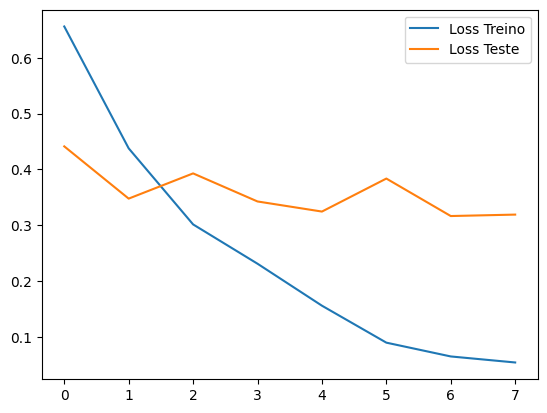

In [31]:
plt.plot(loss_list_complete, label="Loss Treino")
plt.plot(test_loss_list_complete, label="Loss Teste")
plt.legend()
plt.show()

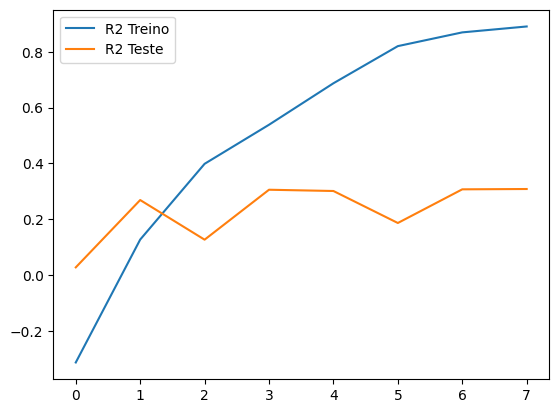

In [32]:
plt.plot(r2_list_complete, label="R2 Treino")
plt.plot(test_r2_list_complete, label="R2 Teste")
plt.legend()
plt.show()

## 7.3. Modelo com Enunciado e Alternativas


In [33]:
data = enem_data[["enunciado", "alternativas", "nu_param_B"]]
data.head()

,enunciado,alternativas,nu_param_B
0,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,0.97831
1,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,0.49169
2,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,3.25992
3,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,0.57925
4,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,0.76307


### 7.3.1. Tokenização (_BERTimbau_)


In [34]:
input_text = [
    f"{enunciado} {alternativa}"
    for enunciado, alternativa in zip(
        data.enunciado.tolist(), data.alternativas.tolist()
    )
]
input_text[:5]

['No império africano do Mali, no século XIV, Tombuctu foi centro de um comércio internacional onde tudo era negociado — sal, escravos, marﬁm etc. Havia também um grande comércio de livros de história, medicina, astronomia e matemática, além de grande concentração de estudantes. A importância cultural de Tombuctu pode ser percebida por meio de um velho provérbio: “O sal vem do norte, o ouro vem do sul, mas as palavras de Deus e os tesouros da sabedoria vêm de Tombuctu”.Uma explicação para o dinamismo dessa cidade e sua importância histórica no período mencionado era o(a) A:  isolamento geográﬁco do Saara ocidental; B:  exploração intensiva de recursos naturais; C:  posição relativa nas redes de circulação; D:  tráﬁco transatlântico de mão de obra servil; E:  competição econômica dos reinos da região',
 'Após a Declaração Universal dos Direitos Humanos pela ONU, em 1948, a Unesco publicou estudos de cientistas de todo o mundo que desqualiﬁcaram as doutrinas racistas e demonstraram a uni

In [35]:
# Tokenizando os textos do enunciado
encoded_corpus = tokenizer(
    text=input_text,
    add_special_tokens=True,
    padding="max_length",
    truncation="longest_first",
    max_length=512,
    return_attention_mask=True,
)

# Coletando input_ids (features)
input_ids = encoded_corpus["input_ids"]
attention_mask = encoded_corpus["attention_mask"]

# Coletando labels (target)
labels = data.nu_param_B.to_numpy()

In [36]:
# Separando dados para validação (20% para validação / 80% para treino e teste)
seed = 42

train_and_test_inputs, val_inputs, train_and_test_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=seed
)
train_and_test_masks, val_masks, _, _ = train_test_split(
    attention_mask, labels, test_size=0.2, random_state=seed
)

In [37]:
# Separando treino e teste (10% dos dados para teste/ 90% para treino)

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    train_and_test_inputs, train_and_test_labels, test_size=0.1, random_state=seed
)
train_masks, test_masks, _, _ = train_test_split(
    train_and_test_masks, train_and_test_labels, test_size=0.1, random_state=seed
)

In [38]:
batch_size = 8

train_dataloader = create_dataloaders(
    train_inputs, train_masks, train_labels, batch_size
)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

### 7.3.2. Criando Camada de Regressão no BERT


In [39]:
# Definindo classe Bert + Camada de Regressão
class BertimbauRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bertimbau=False):
        super(BertimbauRegressor, self).__init__()
        D_in, D_out = 768, 1

        # Pre-trained BERTimbau Neural Network
        self.bertimbau = AutoModel.from_pretrained(
            "neuralmind/bert-base-portuguese-cased"
        )

        # Regressor Layer (Takes 768 input from pre-trained BERT and outputs one value)
        self.regressor = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(D_in, D_out))
        self.double()

    def forward(self, input_ids, attention_masks):
        outputs = self.bertimbau(input_ids=input_ids, attention_mask=attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

In [40]:
# Iniciando Modelo Bertimbau Regressor
model = BertimbauRegressor(drop_rate=0.2)

### 7.3.3. Configurando Ambiente de Treinamento


In [41]:
torch.cuda.empty_cache()

In [42]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"No GPU available, using CPU.")
    device = torch.device("cpu")

Training on GPU: Tesla T4


In [43]:
model.to(device)

BertimbauRegressor(
  (bertimbau): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### 7.3.4. Treinamento


In [ ]:
# Definindo o otimizador como o BERT original
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-5, eps=1e-8
)  # Same as BERT Paper

# MSE loss is the most common for Regression Tasks
loss_function = nn.MSELoss()

# Definindo número de épocas
epochs = 8
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Treinamento
(
    model,
    loss_list,
    rmse_list,
    test_loss_list,
    test_rmse_list,
    r2_train_list,
    r2_test_list,
) = train_bert(
    model,
    optimizer,
    scheduler,
    loss_function,
    epochs,
    train_dataloader,
    test_dataloader,
    device,
    patience=3,
    clip_value=2,
)


--------
Epoch: 1/8
  MSE Train: 0.7236 | Test: 0.4419
  RMSE Train: 0.7835 | Test: 0.6514
  R2 Train: -0.4474 | Test: 0.0968
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 2/8
  MSE Train: 0.3468 | Test: 0.4467
  RMSE Train: 0.5628 | Test: 0.6579
  R2 Train: 0.3053 | Test: 0.0423
  Loss de validação não melhorou por 1 época(s).

--------
Epoch: 3/8
  MSE Train: 0.1957 | Test: 0.4350
  RMSE Train: 0.4095 | Test: 0.6527
  R2 Train: 0.6093 | Test: 0.0719
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 4/8
  MSE Train: 0.1399 | Test: 0.4104
  RMSE Train: 0.3421 | Test: 0.6303
  R2 Train: 0.7197 | Test: 0.1207
  Loss de validação melhorou. Salvando modelo...

--------
Epoch: 5/8
  MSE Train: 0.0949 | Test: 0.5705
  RMSE Train: 0.2911 | Test: 0.7311
  R2 Train: 0.8103 | Test: -0.1336
  Loss de validação não melhorou por 1 época(s).

--------
Epoch: 6/8
  MSE Train: 0.0622 | Test: 0.6216
  RMSE Train: 0.2312 | Test: 0.7874
  R2 Train: 0.8754 | Test: -0.3

### 7.3.5. Resultados

In [45]:
print("Melhor RMSE de Treino: ", min(rmse_list).cpu().detach().numpy())
print("Melhor RMSE de Teste: ", min(test_rmse_list).cpu().detach().numpy())
print("Melhor R2 de Treino: ", max(r2_train_list).cpu().detach().numpy())
print("Melhor R2 de Teste: ", max(r2_test_list).cpu().detach().numpy())

Melhor RMSE de Treino:  0.2260117143302775
Melhor RMSE de Teste:  0.6302747597046321
Melhor R2 de Treino:  0.8858090516402899
Melhor R2 de Teste:  0.12067488799464354


In [46]:
loss_list_complete = []
rmse_list_complete = []
r2_list_complete = []
test_loss_list_complete = []
test_rmse_list_complete = []
test_r2_list_complete = []

for value in loss_list:
    loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in rmse_list:
    rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_train_list:
    r2_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_loss_list:
    test_loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_rmse_list:
    test_rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_test_list:
    test_r2_list_complete.append(float(value.cpu().detach().numpy()))

In [47]:
dict_results = {
    "loss_list": loss_list_complete,
    "rmse_list": rmse_list_complete,
    "r2_list": r2_list_complete,
    "test_loss_list": test_loss_list_complete,
    "test_rmse_list": test_rmse_list_complete,
    "test_r2_list": test_r2_list_complete,
}
df_results = pd.DataFrame(dict_results)

df_results.head(3)

,loss_list,rmse_list,r2_list,test_loss_list,test_rmse_list,test_r2_list
0,0.723594,0.783455,-0.447445,0.441852,0.651351,0.096810
1,0.346761,0.562808,0.305345,0.446739,0.657876,0.042332
2,0.195680,0.409487,0.609294,0.435026,0.652743,0.071862


In [48]:
df_results.to_pickle("df_results.pkl")

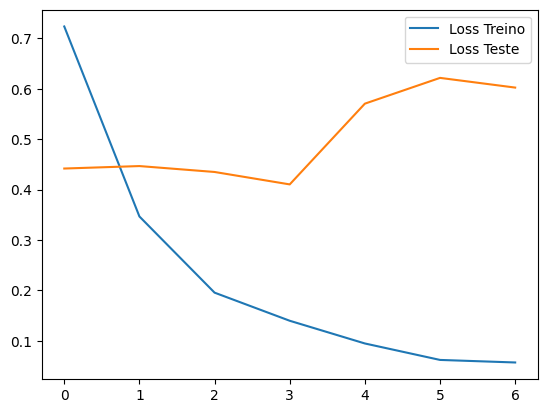

In [49]:
import matplotlib.pyplot as plt

plt.plot(loss_list_complete, label="Loss Treino")
plt.plot(test_loss_list_complete, label="Loss Teste")
plt.legend()
plt.show()

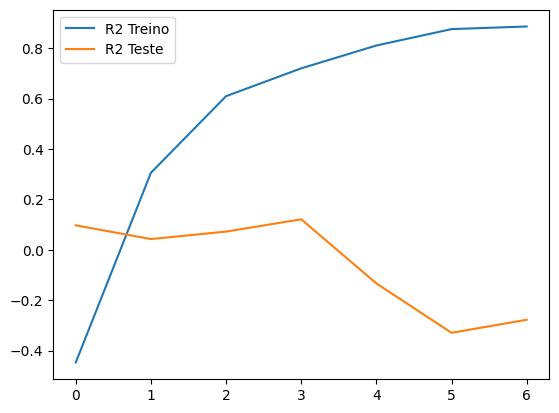

In [50]:
plt.plot(r2_list_complete, label="R2 Treino")
plt.plot(test_r2_list_complete, label="R2 Teste")
plt.legend()
plt.show()

---